## Homework 2: Partial differential  equations

Goal is to solve $\partial_t^2 \phi=\Delta \phi$ on the surface of a sphere. To discretize $\phi$ in space, it can be expanded as a sum over modes l,m (m running from -l to l) in terms of spherical harmonics $Y_{lm}$ like so $\phi(\theta, \varphi)=\sum_{l,m} c^{l,m}(t)*Y_{lm}(\theta, \varphi)$ where $c^{l,m}(t)$ are time dependent coefficients for each mode. 


Thus, substituting this sum in the original equaiton and taking into account that $\Delta Y_{lm}=-l(l+1)Y_{lm}$, it is possible to obtain a second order differential equation for each coefficient: $\frac{\partial^2 c^{l,m}}{\partial t^2}=-l(l+1)c^{l,m}$.


To discretize $\phi$ in time, ODE methods can be used. However, standard ODE methods assume that there's only first order time derivatives, hence the need to define $\psi=\partial_t\phi$ so the original equation gets "split" into two first order equations:


$\psi=\partial_t\phi$ and $\partial_t \psi=\Delta \phi$

$\psi$ can similarly be expanded into spherical harmonics so that the system of equations to solve is: 


$\partial_t c_{\phi}^{l,m}=c_{\psi}^{l,m}$ and  $\partial_t c_{\psi}^{l,m}=\Delta c_{\phi}^{l,m}$

(thanks https://en.wikipedia.org/wiki/Spherical_harmonics for the theory on this!!)








## a) Numerically implement the discretization of $\phi$ in terms of spherical harmonics.


Expanding $\phi$:  $\phi(\theta, \varphi)=\sum_{l} \sum_{m=-l}^{l} c^{l,m} Y_{lm}(\theta ,\varphi)$


To do so numerically, we can use the SphericalHarmonics package. 

In [1]:
using Pkg
Pkg.add("SphericalFunctions")
Pkg.add("SphericalHarmonics")
Pkg.add("QuadGK")
Pkg.add("DifferentialEquations")
Pkg.add("LinearAlgebra")
Pkg.add("CairoMakie")
Pkg.add("LaTeXStrings")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.to

In [2]:
using SphericalHarmonics
using QuadGK
using DifferentialEquations
using LinearAlgebra
using CairoMakie
using LaTeXStrings

In [3]:
#will change l_max here, it's giving me problems if I don't define it globally

l_max=15


15

first we're going to define a function to compute the coefficients c_lm given l, m and the initial function phi_ini as input. To do so we can use the following expression for the coefficients:



$c^{l,m}=\int_0^{2 \pi}\int_0^{\pi}\phi(\theta, \varphi)Y^*_{lm}(\theta, \varphi) \sin{\theta} d\theta d\varphi$

    
    

In [4]:
#shoutout to Luohan for help with this part!!


function coeffs_lm(phi_ini, l,m)

    #define integrand

    integrand(theta, varphi) = phi_ini(theta,varphi).*conj(SphericalHarmonics.sphericalharmonic(theta, varphi; l, m)).*sin(theta)

    # first integration with respect to theta from 0 to pi 

    theta_int(varphi)= quadgk(theta->integrand(theta, varphi), 0, pi)[1]

    #second integration with respect to \varphi from 0 to 2pi and getting the coefficients c_lm

    c_lm= quadgk(theta_int,0, 2*pi)[1]

    return c_lm

end


coeffs_lm (generic function with 1 method)

Now we have the coefficients for a given l and m. So ideally we now want to loop over all l and m to get an array of all coefficients up to some l_max. The length of this array will be given by the total number of modes (so accounting for l going from 0 to l_max and m running from -l to l). 

However, looking at part b) since we take the initial condition to be a gaussian peaked at the north pole (i.e., around $\theta=0$), we can say that the function is azimuthally symmetric and so doesn't really depend on $\varphi$. In other words $\phi(\theta, \varphi)\approx \phi(\theta)$ 


So if we look at the spherical harmonics formula $Y_{ml}=N* e^{im \varphi} P_{ml}(\cos{\theta})$  within the double integral for the 

coefficients $c^{l,m}=\int_0^{2 \pi}\int_0^{\pi}\phi(\theta, \varphi)N* e^{-im \varphi} P_{ml}(\cos{\theta}) \sin{\theta} d\theta d\varphi$  

we notice that the only $\varphi$ dependent term is the exponential. The integral over $\varphi$ of $e^{-im\varphi}$ is only non-zero when $m=0$ so the total number of modes we need to account for is simply l_max+1 (again, thanks Luohan for pointing this out).

In [5]:

#loop over all l up to an upper bound l_max in order to get all the coefficients and store them in an array

function coeffs(phi_ini, l_max)

    modes=l_max+1 #total number of modes (m=0 as only contribution to the double integral)

    coeffs_array=Array{Complex{Float64}}(undef, modes)

    for i in 0:l_max

        m=0 

        #Julia's array indexing starts at 1

        coeffs_array[i+1]= coeffs_lm(phi_ini,i,m)
        
    end

    return coeffs_array 

end

coeffs (generic function with 1 method)

## b) Use an initial condition that is peaked around the North Pole, i.e., that looks similar to a Gaussian with a width equal to 0.2. (The exact initial condition does not matter).




An initial gaussian condition peaked around $\theta=0$, North pole, with $\sigma=0.2$ is described by :


$\phi(\theta, \varphi)= \frac{1}{\sqrt{2 \pi} * 0.2}\exp\left( - 1/2\left( \frac{\theta}{0.2} \right)^2 \right)$

In [6]:
function phi_ini(theta,varphi)

    sigma=0.2

    phi_func= (1/(sqrt(2*pi)*sigma)) * exp(-1/2 .* (theta ./sigma).^2)

    return phi_func

end

phi_ini (generic function with 1 method)

## c) Evolve the system in time to see from t= 0 to t= 10 using your favorite ODE integrator. The resulting evolution should look similar to water waves moving on the surface of a pond, except that the pond is the surface of a sphere.


References for this part: https://discourse.julialang.org/t/callback-function-example-in-differentialequations-jl/102371 and https://docs.sciml.ai/DiffEqDocs/stable/


We'll use the DifferentialEquations package to solve the system of equations. To do so, we first define a single array $U_0$ which will contain in the first half the initial $c_{l,m}$ coefficients for $\phi$, in the second half there will be the initial values for $\psi$ which we can take to be 0 at the t=0 (i.e., we assume the wave to be stationary initially). 

After this we'll define a function, wave_equation!, containing the system of equations we want to solve. This function can then be passed into the ODE solver from the package alongside the initial array $U_0$ and the time span we wish to evolve the wave for. 


In [7]:

#phi initial coefficients

c_initial=coeffs(phi_ini,l_max)

#psi initial coefficients (all zero)

psi_initial=zeros(Complex{Float64},l_max+1)

#initial U_0 array

u_0=vcat(c_initial, psi_initial)

32-element Vector{ComplexF64}:
   0.1395507372808478 + 0.0im
  0.23229368732203962 + 0.0im
   0.2769816494083776 + 0.0im
   0.2909032996973435 + 0.0im
  0.28138355107081153 + 0.0im
   0.2550324885377448 + 0.0im
  0.21844196429744586 + 0.0im
   0.1776717284147017 + 0.0im
   0.1376410608435837 + 0.0im
  0.10176376560658756 + 0.0im
  0.07190517448272174 + 0.0im
  0.04860591622958131 + 0.0im
 0.031456452674349156 + 0.0im
                      ⋮
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im

In [8]:

function wave_equation!(du,u,p,t)


    modes=l_max+1

    #loop to define the equations of the system

    for l in 0:l_max

        phi_index=l+1 #first half, containing the phi values
        psi_index=l+1+modes # second half with the values related to psi

        #define the first equation d/dt c_phi=c_psi

        du[phi_index]=u[psi_index]

        #define second equation d/dt psi= -l(l+1)c_phi

        du[psi_index]=-l*(l+1)*u[phi_index]
        
    end

end




wave_equation! (generic function with 1 method)

In [9]:
#actually solving the ODE

#time from 0 to 10

tspan=(0.0,10.0)

prob=ODEProblem(wave_equation!, u_0,tspan)

sol=solve(prob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 154-element Vector{Float64}:
  0.0
  0.00015701905857015388
  0.0017272096442716926
  0.009412755703028082
  0.02471655871059647
  0.046118652185416054
  0.07347852072235994
  0.10712179759847897
  0.1441901732590009
  0.18541134912751436
  0.23334021509777425
  0.28077549980977584
  0.3347443721526775
  ⋮
  9.266883357656033
  9.335652167118567
  9.405282554206558
  9.475034267538993
  9.542897457238778
  9.6142427039348
  9.682682761589104
  9.751941820172148
  9.822022865805376
  9.890974748684721
  9.960429068845121
 10.0
u: 154-element Vector{Vector{ComplexF64}}:
 [0.1395507372808478 + 0.0im, 0.23229368732203962 + 0.0im, 0.2769816494083776 + 0.0im, 0.2909032996973435 + 0.0im, 0.28138355107081153 + 0.0im, 0.2550324885377448 + 0.0im, 0.21844196429744586 + 0.0im, 0.1776717284147017 + 0.0im, 0.1376410608435837 + 0.0im, 0.10176376560658756 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 

In [10]:
#rebuild phi from the (now time evolved) coefficients so that we can plot it

function phi_rebuild(sol,t,theta,varphi,l_max)

    #solve ODE at t

    u_t=sol(t)

    modes=l_max+1

    phi_func=0.0+0im 

    for l in 0:l_max

        c_lm=u_t[l+1] #first half of the u array which contains the (now time evolved) coefficients of phi

        #get phi with the sum of the c_lm (t) coefficients multiplying the spherical harmonics
        #i.e., original expansion of phi in terms of spherical harmonics
        
        phi_func+=c_lm*SphericalHarmonics.sphericalharmonic(theta,varphi;l=l,m=0)
        
    end
    return phi_func
    
end
   

phi_rebuild (generic function with 1 method)

In [11]:
#define a function to create a plot of phi at specific times t and for the global l_max

function plot_func(sol,t,l_max)
    
    theta_grid=range(0,pi,length=100)
    
    varphi_grid=range(0,2*pi,length=100)
    
    phi_amplitude=[real(phi_rebuild(sol,t,theta,varphi,l_max)) for 
            varphi in varphi_grid, theta in theta_grid]

    fig=Figure()
    ax=Axis(fig[1,1],xlabel=L"\theta",ylabel=L"\phi",title=L"\phi (\theta,\varphi) \ at \ t=%$(t) \ and \ l_{max}=%$(l_max)" , xlabelsize=25,ylabelsize=25,titlesize = 25 )
    heatmap!(ax,theta_grid,varphi_grid,phi_amplitude;colormap=:plasma) 
    fig
end



plot_func (generic function with 1 method)

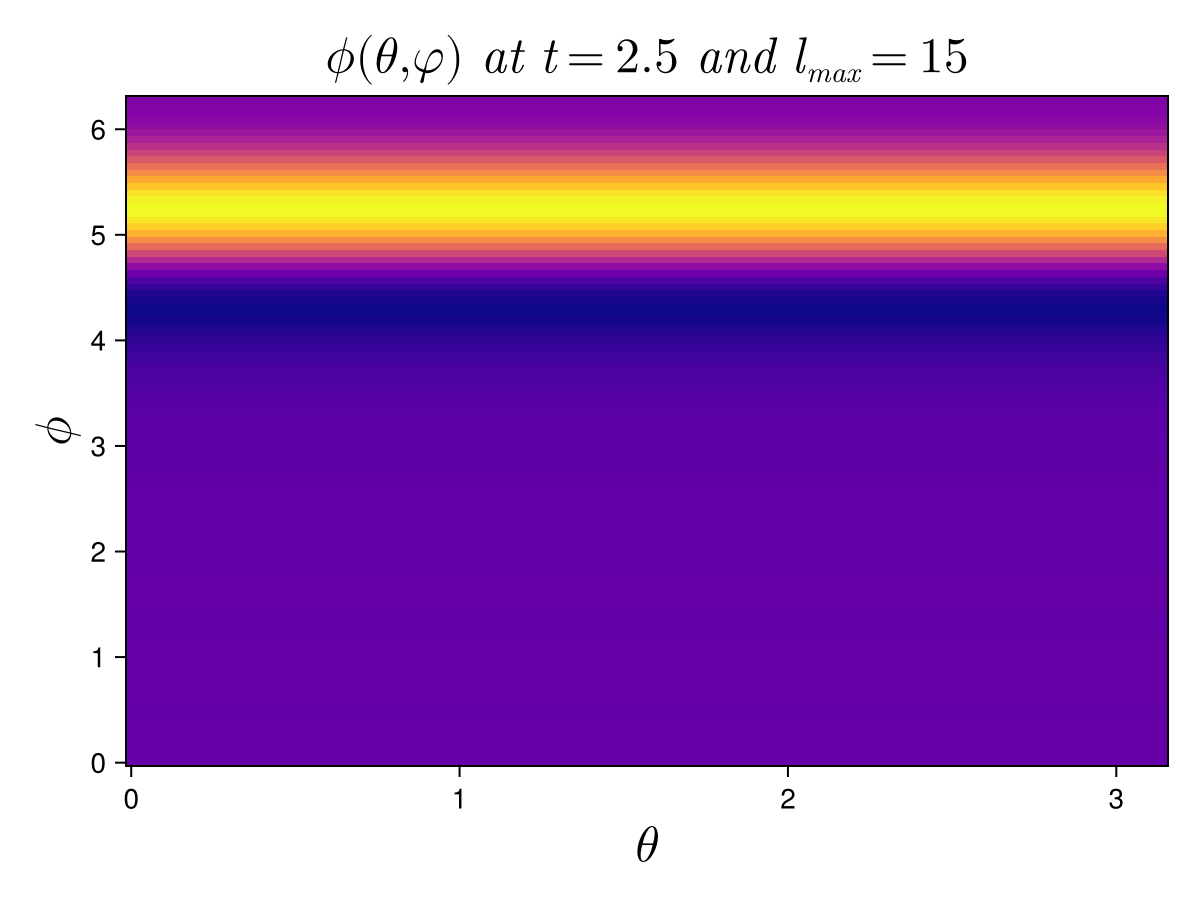

CairoMakie.Screen{IMAGE}


In [12]:

fig1=plot_func(sol,2.5,l_max)
display(fig1)


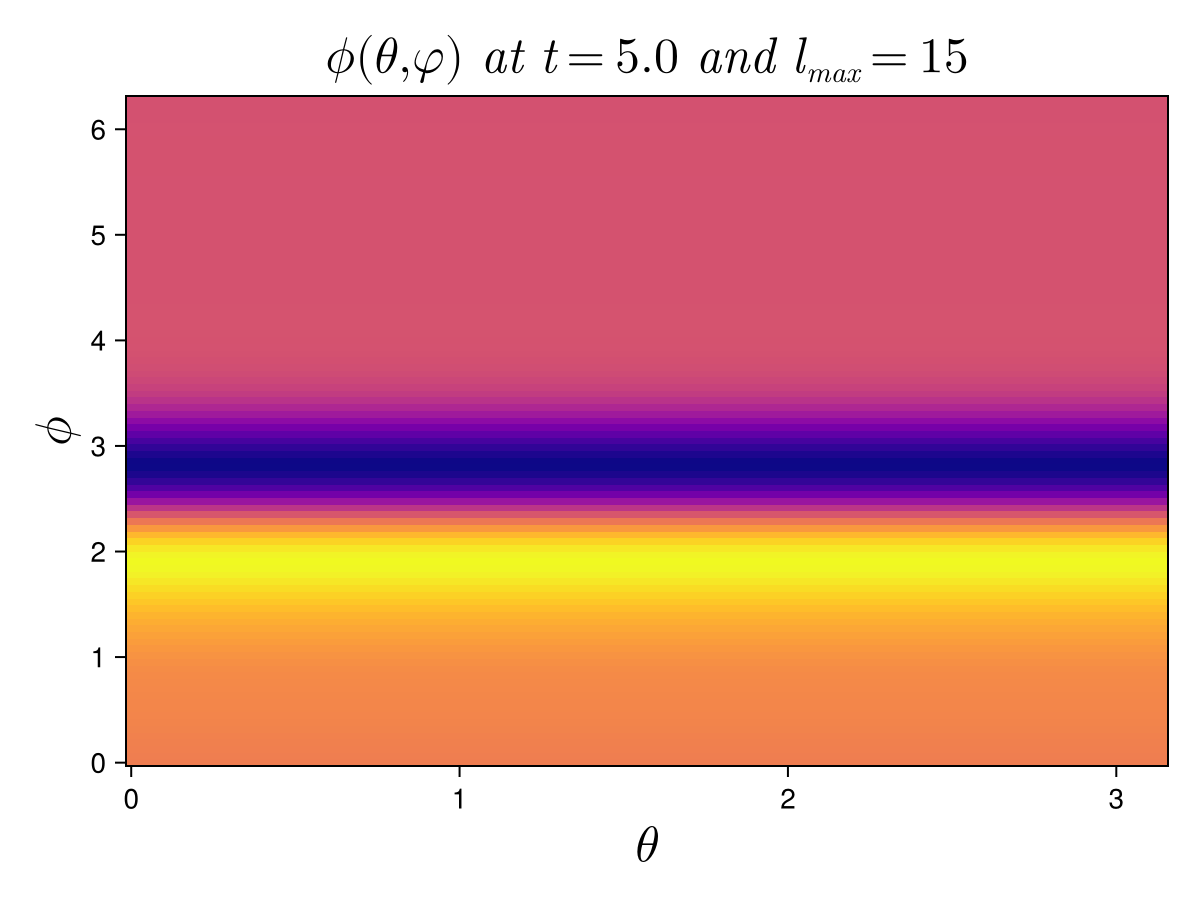

CairoMakie.Screen{IMAGE}


In [13]:
fig2=plot_func(sol,5.0,l_max)
display(fig2)

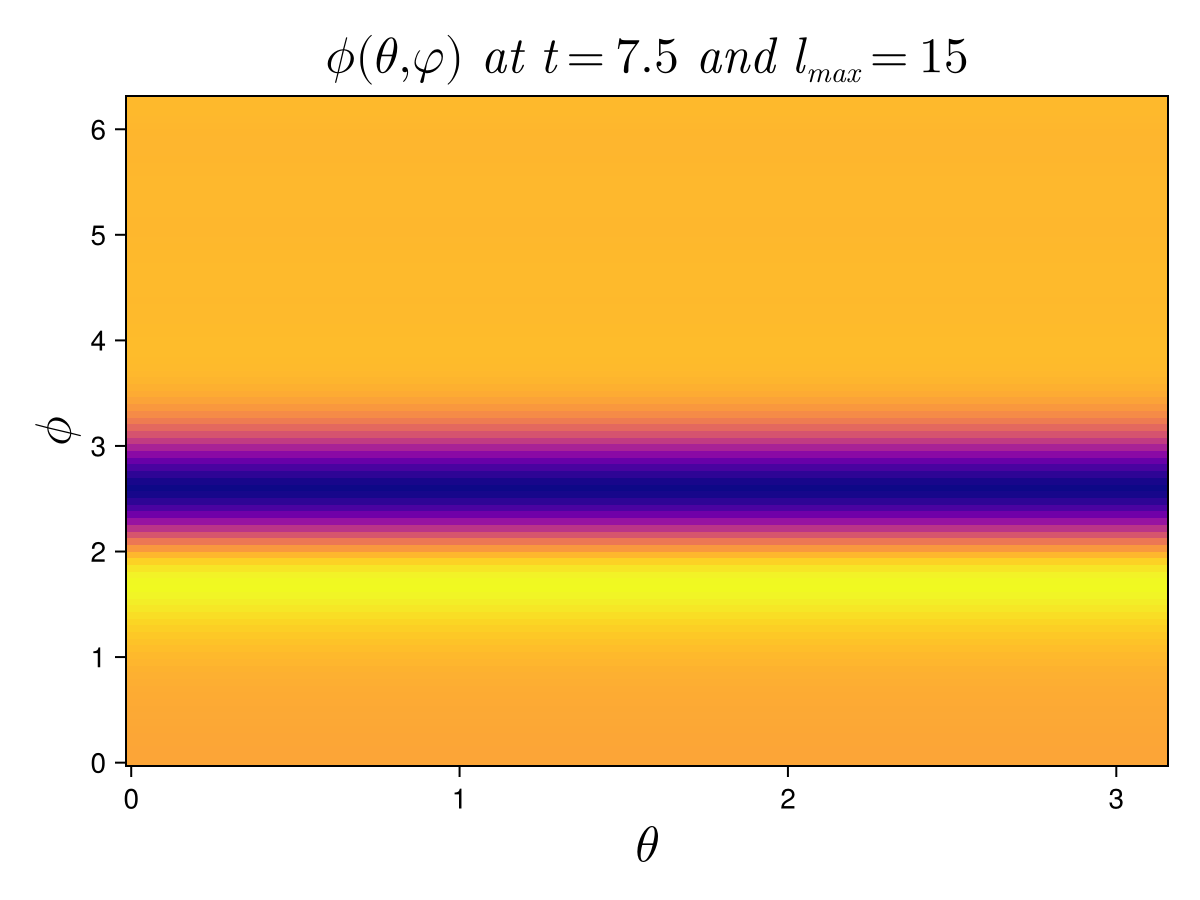

CairoMakie.Screen{IMAGE}


In [14]:
fig3=plot_func(sol,7.5,l_max)
display(fig3)

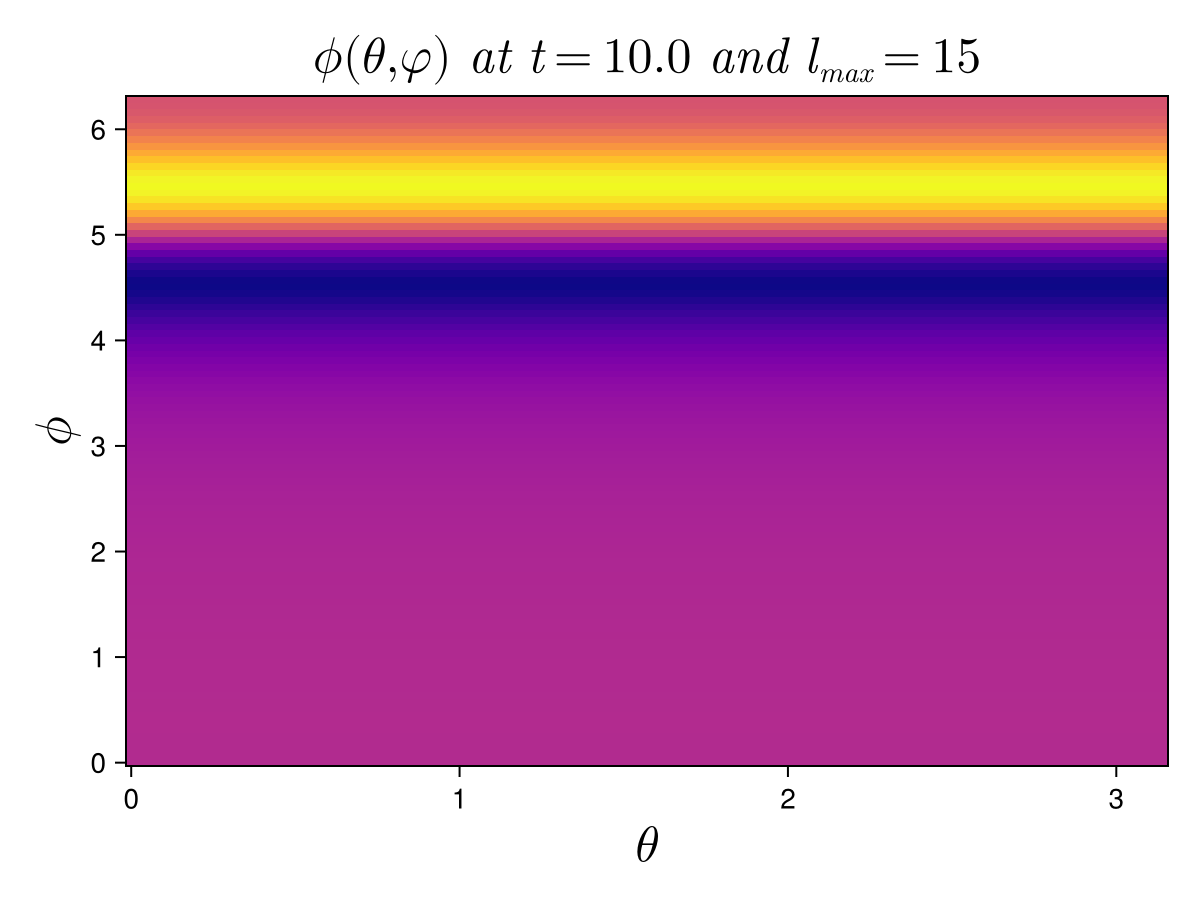

CairoMakie.Screen{IMAGE}


In [15]:
fig4=plot_func(sol,10.0,l_max)
display(fig4)



In [113]:
save("T25L15.png", fig1)
save("T50L15.png", fig2)
save("T75L15.png", fig3)
save("T10L15.png", fig4)

CairoMakie.Screen{IMAGE}
